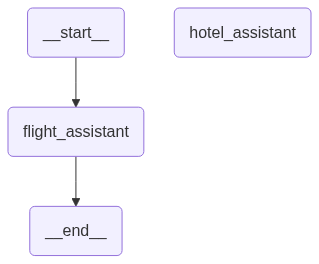

In [3]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command
from langchain_openai import AzureOpenAIEmbeddings,AzureChatOpenAI
from azure.identity import DefaultAzureCredential,get_bearer_token_provider

token_provider= get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4o-mini"
)

def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Transfer to {agent_name}"

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState], 
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        return Command(  
            goto=agent_name,  
            update={"messages": state["messages"] + [tool_message]},  
            graph=Command.PARENT,  
        )
    return handoff_tool

# Handoffs
transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant.",
)

# Simple agent tools
def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."

def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f"Successfully booked a flight from {from_airport} to {to_airport}."

# Define agents
flight_assistant = create_react_agent(
    model=model,
    tools=[book_flight, transfer_to_hotel_assistant],
    prompt="You are a flight booking assistant",
    name="flight_assistant"
)
hotel_assistant = create_react_agent(
    model=model,
    tools=[book_hotel, transfer_to_flight_assistant],
    prompt="You are a hotel booking assistant",
    name="hotel_assistant"
)

# Define multi-agent graph
multi_agent_graph = (
    StateGraph(MessagesState)
    .add_node(flight_assistant)
    .add_node(hotel_assistant)
    .add_edge(START, "flight_assistant")
    .compile()
)
multi_agent_graph

# Run the multi-agent graph
#for chunk in multi_agent_graph.stream(
#    {
#        "messages": [
#            {
#                "role": "user",
#                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
#            }
#        ]
#    }
#):
#    print(chunk)
#    print("\n")